In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 스페이스쉽 타이타닉 데이터 다운로드

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dahanjunho","key":"a6df409b34db427a1981452219262027"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c spaceship-titanic

100% 299k/299k [00:00<00:00, 872kB/s]
100% 299k/299k [00:00<00:00, 871kB/s]


In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
!unzip spaceship-titanic.zip

Archive:  spaceship-titanic.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
# !mkdir /content/drive/MyDrive/ML_Data/kaggle/spaceship-titanic

mkdir: cannot create directory ‘/content/drive/MyDrive/ML_Data/kaggle/spaceship-titanic’: File exists


In [ ]:
!cp train.csv /content/drive/MyDrive/ML_Data/kaggle/spaceship-titanic
!cp test.csv /content/drive/MyDrive/ML_Data/kaggle/spaceship-titanic
!cp sample_submission.csv /content/drive/MyDrive/ML_Data/kaggle/spaceship-titanic

In [ ]:
!rm spaceship-titanic.zip
!rm sample_submission.csv
!rm train.csv
!rm test.csv

# 라이브러리 로드

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
rc = {
    "axes.facecolor": "#F6F6F6",
    "figure.facecolor": "#B8B8B8",
    "axes.edgecolor": "#000000",
    "grid.color": "#C4C4C4",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)

# Transported 예측하기
* 이진 분류기 만들기

* train.csv - Personal records for about two-thirds (\~8700) of the passengers, to be used as training data.
* PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
* CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
Destination - The planet the passenger will be debarking to.
* Age - The age of the passenger.
* VIP - Whether the passenger has paid for special VIP service during the voyage.
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* Name - The first and last names of the passenger.
* Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
* test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.


In [117]:
train = pd.read_csv('/content/drive/MyDrive/ML_Data/kaggle/spaceship-titanic/train.csv')
test = pd.read_csv('/content/drive/MyDrive/ML_Data/kaggle/spaceship-titanic/test.csv')

## EDA

In [118]:
train.shape

(8693, 14)

In [119]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [92]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [93]:
train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [120]:
train[['Cabin_deck', 'Cabin_num', 'Cabin_side']] = train.loc[:,'Cabin'].str.split('/', expand=True)
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Cabin_deck,Cabin_num,Cabin_side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S


In [121]:
train['Cabin_deck'].value_counts()

F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: Cabin_deck, dtype: int64

In [122]:
cabin_cols = ['Cabin_deck', 'Cabin_num', 'Cabin_side']

for col in cabin_cols:
  print(f'{col} values: {train[col].nunique()}')
  print(f'{train[col].value_counts()}')
  print()

Cabin_deck values: 8
F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: Cabin_deck, dtype: int64

Cabin_num values: 1817
82      28
86      22
19      22
56      21
176     21
        ..
1644     1
1515     1
1639     1
1277     1
1894     1
Name: Cabin_num, Length: 1817, dtype: int64

Cabin_side values: 2
S    4288
P    4206
Name: Cabin_side, dtype: int64



* There are too many different values of Cabin_num
* Decided to drop the Cabin_num col

In [97]:
train = train.drop(['Cabin', 'Cabin_num'], axis=1)
train.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Cabin_deck,Cabin_side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,S


In [98]:
type(train)

pandas.core.frame.DataFrame

In [99]:
train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
Cabin_deck      199
Cabin_side      199
dtype: int64

In [100]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Name          8493 non-null   object 
 12  Transported   8693 non-null   bool   
 13  Cabin_deck    8494 non-null   object 
 14  Cabin_side    8494 non-null   object 
dtypes: bool(1), float64(6), object(8)
memory usage: 959.4+ KB


In [123]:
train['Transported'] = train['Transported'].map({False:0, True:1})
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Cabin_deck,Cabin_num,Cabin_side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,F,1,S


In [124]:
train_cat = train.select_dtypes(exclude=['number'])
train_num = train.select_dtypes(include=['number'])
train_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  8693 non-null   object
 1   HomePlanet   8492 non-null   object
 2   CryoSleep    8476 non-null   object
 3   Cabin        8494 non-null   object
 4   Destination  8511 non-null   object
 5   VIP          8490 non-null   object
 6   Name         8493 non-null   object
 7   Cabin_deck   8494 non-null   object
 8   Cabin_num    8494 non-null   object
 9   Cabin_side   8494 non-null   object
dtypes: object(10)
memory usage: 679.3+ KB


In [103]:
train_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           8514 non-null   float64
 1   RoomService   8512 non-null   float64
 2   FoodCourt     8510 non-null   float64
 3   ShoppingMall  8485 non-null   float64
 4   Spa           8510 non-null   float64
 5   VRDeck        8505 non-null   float64
 6   Transported   8693 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 475.5 KB


In [104]:
train_cat.describe()

,PassengerId,HomePlanet,CryoSleep,Destination,VIP,Name,Cabin_deck,Cabin_side
count,8693,8492,8476,8511,8490,8493,8494,8494
unique,8693,3,2,3,2,8473,8,2
top,0001_01,Earth,False,TRAPPIST-1e,False,Gollux Reedall,F,S
freq,1,4602,5439,5915,8291,2,2794,4288


In [105]:
train_num.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791,0.503624
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189,0.500016
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000,1.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1.000000


In [106]:
train_num.columns

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported'],
      dtype='object')

IndexError: ignored

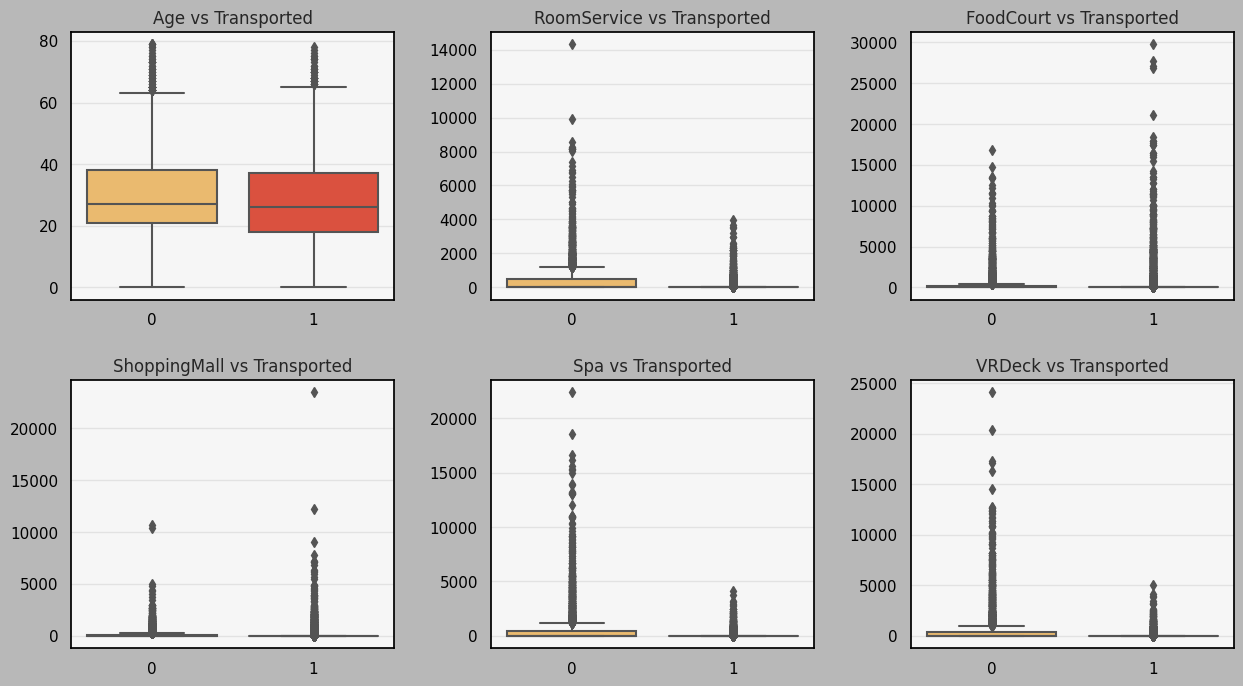

In [76]:
fig, ax = plt.subplots(2,3,figsize=(15,8))
ax = ax.flatten()
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i, col in enumerate(train_num.columns):
  sns.boxplot(train, x="Transported", y=col, order=[0,1], palette='YlOrRd', ax=ax[i])
  ax[i].set_ylabel("")
  ax[i].set_xlabel("")
  ax[i].set_title(f"{col} vs Transported")

In [77]:
sum(train["Spa"] == 0)

5324

In [78]:
many_zeros = train_num.columns[1:]

for col in many_zeros:
  print(f"{col}: {round((sum(train[col] == 0)/len(train[col])) * 100, 2)}%")

RoomService: 64.16%
FoodCourt: 62.76%
ShoppingMall: 64.27%
Spa: 61.24%
VRDeck: 63.21%
Transported: 49.64%


* Age를 제외한 나머지 컬럼들은 분포가 유의미하지 않다. (0이 너무 많음)
* Age의 분포는 살짝 왼쪽으로 치우쳐있음
* numeric에서 Age만 사용

In [107]:
cols = list(train_cat.columns)
cols

['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Destination',
 'VIP',
 'Name',
 'Cabin_deck',
 'Cabin_side']

In [108]:
cols.remove('Name')
cols.append('Age')
cols.append('Transported')

In [109]:
cols

['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Destination',
 'VIP',
 'Cabin_deck',
 'Cabin_side',
 'Age',
 'Transported']

In [125]:
train = train[cols]
train = train.drop('PassengerId', axis=1)
train

,HomePlanet,CryoSleep,Destination,VIP,Cabin_deck,Cabin_side,Age,Transported
0,Europa,False,TRAPPIST-1e,False,B,P,39.0,0
1,Earth,False,TRAPPIST-1e,False,F,S,24.0,1
2,Europa,False,TRAPPIST-1e,True,A,S,58.0,0
3,Europa,False,TRAPPIST-1e,False,A,S,33.0,0
4,Earth,False,TRAPPIST-1e,False,F,S,16.0,1
...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,True,A,P,41.0,0
8689,Earth,True,PSO J318.5-22,False,G,S,18.0,0
8690,Earth,False,TRAPPIST-1e,False,G,S,26.0,1
8691,Europa,False,55 Cancri e,False,E,S,32.0,0


In [126]:
features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin_deck', 'Cabin_side']

for feature in features:
  print(feature)
  print("------------------------------------------")
  print(train[feature].value_counts())

HomePlanet
------------------------------------------
Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64
CryoSleep
------------------------------------------
False    5439
True     3037
Name: CryoSleep, dtype: int64
Destination
------------------------------------------
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64
VIP
------------------------------------------
False    8291
True      199
Name: VIP, dtype: int64
Cabin_deck
------------------------------------------
F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: Cabin_deck, dtype: int64
Cabin_side
------------------------------------------
S    4288
P    4206
Name: Cabin_side, dtype: int64


In [131]:
train_imp1 = train.copy()
train_imp2 = train.copy()
train_imp3 = train.copy()

In [132]:
train.isnull().sum()

HomePlanet     201
CryoSleep      217
Destination    182
VIP            203
Cabin_deck     199
Cabin_side     199
Age            179
Transported      0
dtype: int64

### Listwise Deletion

In [135]:
train_imp1 = train_imp1.dropna()
print(f"Original Data: {train.shape} => Listwise Deletion: {train_imp1.shape}")

Original Data: (8693, 8) => Listwise Deletion: (7572, 8)


* drop 1121 rows that include NA values

In [142]:
train_imp1 = train_imp1.reset_index()
train_imp1 = train_imp1.drop('index', axis=1)

In [143]:
X_train, y_train = train_imp1.drop(columns='Transported'), train_imp1['Transported']
X_train

,HomePlanet,CryoSleep,Destination,VIP,Cabin_deck,Cabin_side,Age
0,Europa,False,TRAPPIST-1e,False,B,P,39.0
1,Earth,False,TRAPPIST-1e,False,F,S,24.0
2,Europa,False,TRAPPIST-1e,True,A,S,58.0
3,Europa,False,TRAPPIST-1e,False,A,S,33.0
4,Earth,False,TRAPPIST-1e,False,F,S,16.0
...,...,...,...,...,...,...,...
7567,Europa,False,55 Cancri e,True,A,P,41.0
7568,Earth,True,PSO J318.5-22,False,G,S,18.0
7569,Earth,False,TRAPPIST-1e,False,G,S,26.0
7570,Europa,False,55 Cancri e,False,E,S,32.0


In [146]:
from sklearn.preprocessing import LabelEncoder

features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin_deck', 'Cabin_side']

for feature in features:
  le = LabelEncoder()
  le = le.fit(X_train[feature])
  X_train[feature] = le.transform(X_train[feature])

X_train

,HomePlanet,CryoSleep,Destination,VIP,Cabin_deck,Cabin_side,Age
0,1,0,2,0,1,0,39.0
1,0,0,2,0,5,1,24.0
2,1,0,2,1,0,1,58.0
3,1,0,2,0,0,1,33.0
4,0,0,2,0,5,1,16.0
...,...,...,...,...,...,...,...
7567,1,0,0,1,0,0,41.0
7568,0,1,1,0,6,1,18.0
7569,0,0,2,0,6,1,26.0
7570,1,0,0,0,4,1,32.0


In [144]:
y_train

0       0
1       1
2       0
3       0
4       1
       ..
7567    0
7568    0
7569    1
7570    0
7571    1
Name: Transported, Length: 7572, dtype: int64

In [147]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

model1 = LogisticRegression(random_state=42)
cv1 = cross_validate(model1, X_train, y_train, cv=5, scoring='accuracy')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [152]:
round(cv1['test_score'].mean(), 4) * 100

71.87

* VIP True 값이 굉장히 적다.
* Cabin과 Name은 없애기로 결정

### Mean / Median imputation

In [158]:
features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin_deck', 'Cabin_side']

for feature in features:
  print(train_imp2[feature].mode())
print(round(train_imp2['Age'].mean()))

0    Earth
Name: HomePlanet, dtype: object
0    False
Name: CryoSleep, dtype: object
0    TRAPPIST-1e
Name: Destination, dtype: object
0    False
Name: VIP, dtype: object
0    F
Name: Cabin_deck, dtype: object
0    S
Name: Cabin_side, dtype: object
29


In [171]:
for feature in features:
  mode = train_imp2[feature].mode()[0]
  null_idx = train_imp2[feature].isnull()
  train_imp2.loc[null_idx, feature] = mode

mean = round(train_imp2['Age'].mean())
train_imp2['Age'] = train_imp2['Age'].fillna(mean)

train_imp2.isnull().sum()

HomePlanet     0
CryoSleep      0
Destination    0
VIP            0
Cabin_deck     0
Cabin_side     0
Age            0
Transported    0
dtype: int64

In [172]:
train_imp2.shape

(8693, 8)

In [175]:
X_train, y_train = train_imp2.drop(columns='Transported'), train_imp2['Transported']

features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin_deck', 'Cabin_side']

for feature in features:
  le = LabelEncoder()
  le = le.fit(X_train[feature])
  X_train[feature] = le.transform(X_train[feature])

X_train

,HomePlanet,CryoSleep,Destination,VIP,Cabin_deck,Cabin_side,Age
0,1,0,2,0,1,0,39.0
1,0,0,2,0,5,1,24.0
2,1,0,2,1,0,1,58.0
3,1,0,2,0,0,1,33.0
4,0,0,2,0,5,1,16.0
...,...,...,...,...,...,...,...
8688,1,0,0,1,0,0,41.0
8689,0,1,1,0,6,1,18.0
8690,0,0,2,0,6,1,26.0
8691,1,0,0,0,4,1,32.0


In [176]:
model2 = LogisticRegression(random_state=42)
cv2 = cross_validate(model2, X_train, y_train, cv=5, scoring='accuracy')
round(cv2['test_score'].mean(), 4) * 100

71.6

### Model-based Imputation
* MICE 사용

In [178]:
!pip install miceforest

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.1 MB/s eta 0:00:00


In [193]:
train_imp3.isnull().sum()

HomePlanet     201
CryoSleep      217
Destination    182
VIP            203
Cabin_deck     199
Cabin_side     199
Age            179
Transported      0
dtype: int64

In [195]:
cats = train_imp3.select_dtypes(exclude='number').columns

for feature in cats:
  train_imp3[feature] = train_imp3[feature].astype('category')

train_imp3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   HomePlanet   8492 non-null   category
 1   CryoSleep    8476 non-null   category
 2   Destination  8511 non-null   category
 3   VIP          8490 non-null   category
 4   Cabin_deck   8494 non-null   category
 5   Cabin_side   8494 non-null   category
 6   Age          8514 non-null   float64 
 7   Transported  8693 non-null   int64   
dtypes: category(6), float64(1), int64(1)
memory usage: 187.8 KB


In [196]:
import time
import miceforest as mf

start_time = time.time()

kds = mf.ImputationKernel(
    train_imp3,
    random_state=42
)
kds.mice(5)
train_imp3 = kds.complete_data()

end_time = time.time()
t = round(end_time - start_time, 2)
print(f"{t}sec")

/usr/local/lib/python3.10/dist-packages/miceforest/ImputationKernel.py:371: UserWarning: [Cabin_deck] have very rare categories, it is a good idea to group these, or set the min_data_in_leaf parameter to prevent lightgbm from outputting 0.0 probabilities.
  warn(


20.3sec


In [200]:
X_train, y_train = train_imp3.drop(columns='Transported'), train_imp3['Transported']

features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin_deck', 'Cabin_side']

for feature in features:
  le = LabelEncoder()
  le = le.fit(X_train[feature])
  X_train[feature] = le.transform(X_train[feature])

X_train

,HomePlanet,CryoSleep,Destination,VIP,Cabin_deck,Cabin_side,Age
0,1,0,2,0,1,0,39.0
1,0,0,2,0,5,1,24.0
2,1,0,2,1,0,1,58.0
3,1,0,2,0,0,1,33.0
4,0,0,2,0,5,1,16.0
...,...,...,...,...,...,...,...
8688,1,0,0,1,0,0,41.0
8689,0,1,1,0,6,1,18.0
8690,0,0,2,0,6,1,26.0
8691,1,0,0,0,4,1,32.0


In [202]:
model3 = LogisticRegression(random_state=42)
cv3 = cross_validate(model3, X_train, y_train, cv=5, scoring='accuracy')
round(cv3['test_score'].mean(), 4) * 100

72.00999999999999

In [206]:
round(cv3['test_score'].mean(), 4) * 100

72.00999999999999

## 데이터 전처리 파이프라인

In [ ]:
list(X_train_cat.columns)

['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

cat_features = list(X_train_cat.columns)
num_features = ['Age']

pipeline = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(), cat_features),
])

X_train = pipeline.fit_transform(X_train)
X_train

array([[ 0.70084137,  0.        ,  1.        , ...,  1.        ,
         1.        ,  0.        ],
       [-0.33449459,  1.        ,  0.        , ...,  1.        ,
         1.        ,  0.        ],
       [ 2.01226692,  0.        ,  1.        , ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [-0.1964498 ,  1.        ,  0.        , ...,  1.        ,
         1.        ,  0.        ],
       [ 0.21768459,  0.        ,  1.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 1.04595336,  0.        ,  1.        , ...,  1.        ,
         1.        ,  0.        ]])

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)

## 모델 훈련시키기

### 1. LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression()
cv_log_clf = cross_val_score(log_clf, X_train, y_train, cv=5, n_jobs=-1)
cv_log_clf

array([0.71554054, 0.73108108, 0.7       , 0.71467208, 0.72008114])